In [2]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import random
import io 
import PIL 
import freud
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = numpy.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = numpy.array(snapshot.particles.orientation)
    angles = 2 * numpy.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [6]:
m = 5
N_particles = m**2
spacing = 2
K = math.ceil(N_particles ** (1 / 2))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = [(px, py, 0) for px, py in itertools.product(x, x)][:N_particles]
orientation = [(1, 0, 0, 0)] * N_particles

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.orientation = orientation[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, 0, 0, 0, 0]
frame.particles.types = ['Squares']


In [8]:
fn = os.path.join(os.getcwd(), 'lattice_sq_v4.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='lattice_sq_v4.gsd', mode='x') as f:
    f.append(frame)

In [ ]:
########COMPRESS########

In [4]:
m = 5
N_particles = m ** 2
spacing = 20  
target_vf = 0.01 

particle_radius = 1 
particle_volume = (2 * particle_radius) ** 2  
box_volume = N_particles * particle_volume / target_vf
box_size = numpy.sqrt(box_volume) 

positions = numpy.random.uniform(-box_size / 2, box_size / 2, size=(N_particles, 2))
positions = [(px, py, 0) for px, py in positions]  

orientations = [(numpy.cos(random.uniform(0, 2 * numpy.pi)), 
                 numpy.sin(random.uniform(0, 2 * numpy.pi)), 
                 0, 0) for _ in range(N_particles)] 

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = positions
frame.particles.orientation = orientations
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [box_size, box_size, 0, 0, 0, 0]
frame.particles.types = ['Squares']

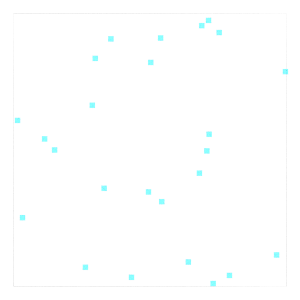

In [5]:
render(frame)

In [6]:
fn = os.path.join(os.getcwd(), 'lattice_sq_v4_cmp.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='lattice_sq_v4_cmp.gsd', mode='x') as f:
    f.append(frame)